## Ensemble Exploration
Questions to find answers to:
- What is a good workflow for passing one image through the ensemble
- What is a suitable loss? (Data is needed for that.)
- Deep mutual learning losses vs standard student teacher loss

In [1]:
import torch
import torch.nn.functional as F

import numpy as np
import cv2
from math import ceil
import matplotlib.pyplot as plt

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warpImage
from utils.encoding import labelMatrixOneHot, dice_coeff


from models.pdd_net.pdd_student import OBELISK2d, deeds2d

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [2]:
flow2 = load_flownet2().cuda()
pwc = load_pwcnet().cuda()

/home/till/uni/MasterThesis/models/pwc_net/models/PWCNet.py:138: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data, mode='fan_in')


In [3]:
net = OBELISK2d()
reg = deeds2d()
init_weights(net)

PWC and Flow2 seem to occupy around 1,5 GB on a graphics card

In [4]:
imgs = torch.load('Data/img.pth')
segs = torch.load('Data/seg.pth')

fix = 6; mov=3
fixed = imgs[fix:fix+1,:,:].float() /255
moving = imgs[mov:mov+1,:,:].float() /255

fixed_seg = segs[fix:fix+1, :,:].float().contiguous()
moving_seg = segs[mov:mov+1,:,:].float().contiguous()

#fixed = F.interpolate(fixed.unsqueeze(0), size=(100,100)).view(1,100,100)
#moving = F.interpolate(moving.unsqueeze(0), size=(100,100)).view(1,100,100)

#fixed_seg = F.interpolate(fixed_seg.unsqueeze(0), size=(100,100)).view(1,100,100)
#moving_seg = F.interpolate(moving_seg.unsqueeze(0), size=(100,100)).view(1,100,100)

C,h,w = fixed.shape

In [5]:
flow_in = preprocessing_flownet(fixed.reshape(h,w,C),moving.reshape(h,w,C)).cuda()

In [6]:
flow_in.shape

torch.Size([1, 3, 2, 320, 256])

In [7]:
flow2_out = flow2(flow_in).cpu()

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [8]:
pwc_in = preprocessing_pwc(fixed.reshape(h,w,C),moving.reshape(h,w,C))

In [9]:
pwc.eval()
pwc_out = pwc(pwc_in.cuda())
pwc_out = pwc_out[0]*20
pwc_out = pwc_out.cpu().data.numpy()

pwc_out = np.swapaxes(np.swapaxes(pwc_out, 0, 1), 1, 2) 

divisor = 64
H_ = int(ceil(h/divisor) * divisor)
W_ = int(ceil(w/divisor) * divisor)

u_ = cv2.resize(pwc_out[:,:,0],(w,h))
v_ = cv2.resize(pwc_out[:,:,1],(w,h))
u_ *= w/ float(W_)
v_ *= h/ float(H_)
pwc_out = np.dstack((u_,v_))

pwc_out.shape

torch.Size([1, 81, 5, 4])


/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(320, 256, 2)

In [10]:
flow2_out = flow2_out.squeeze().cpu().detach().numpy().transpose(1,2,0)
flow2_out.shape

(320, 256, 2)

In [11]:
feat00 = net(fixed.unsqueeze(0))
feat50 = net(moving.unsqueeze(0))

cost_soft, pred_xy = reg(feat00,feat50)

In [12]:
grid_size = 32#25#30

pdd_out = cv2.resize(pred_xy.reshape(grid_size,grid_size,2).detach().numpy(),(w,h))
pdd_out.shape

(320, 256, 2)

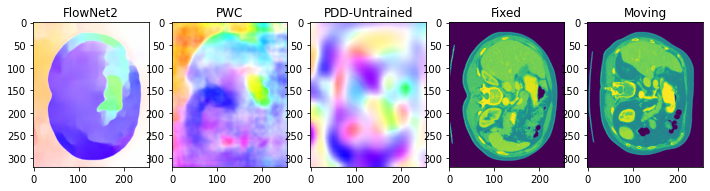

In [13]:
fig = plt.figure(figsize=(12,12))
plt.subplot(251)
plt.title("FlowNet2")
plt.imshow(flow2img(flow2_out))

plt.subplot(252)
plt.title("PWC")
plt.imshow(flow2img(pwc_out))

plt.subplot(253)
plt.title("PDD-Untrained")
plt.imshow(flow2img(pdd_out))

plt.subplot(254)
plt.title('Fixed')
plt.imshow(fixed.squeeze())

plt.subplot(255)
plt.title('Moving')
plt.imshow(moving.squeeze())

So not happy with PWC

BUT! PDD with init_weights, looks quite close to the desired flow. Ish

# Trying to learn on the data

In [14]:
net = OBELISK2d()
reg = deeds2d()
init_weights(net)
net.train()
reg.train()

# 20 epochs should be fine for overfitting
epochs = 20
optimizer = torch.optim.Adam(list(net.parameters())+list(reg.parameters()),lr=0.05)

disp_range = 0.25#0.25
displacement_width = 15#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2) 
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2)

# Testing with only one image to overfit on the flow and check if it works
# verfitting with upscale
diffs = []

# Genrate the flow we want to approximate

for i in range(epochs):
    optimizer.zero_grad()
        
    #teacher_output = flow2(flow_in).cpu()

    # Generate the pdd-output
    fixed.requires_grad = True
    moving.requires_grad=True
    
    feat00 = net(fixed.unsqueeze(0))
    feat50 = net(moving.unsqueeze(0))
    
    soft_cost, pred_xy = reg(feat00,feat50)
    pred_xy = pred_xy.view(1,grid_size,grid_size,2)
    diffloss = 1.5*((pred_xy[0,:,1:,:]-pred_xy[0,:,:-1,:])**2).mean()+\
            1.5*((pred_xy[0,1:,:,:]-pred_xy[0,:-1,:,:])**2).mean()+\
            1.5*((pred_xy[0,:,:,1:]-pred_xy[0,:,:,:-1])**2).mean()
    
    # Not sure what this does. 
    nonlocal_label = (F.grid_sample(labelMatrixOneHot(moving_seg,9).float(),grid_xy+shift_xy,padding_mode='border')\
                          *soft_cost.view(1,-1,grid_size**2,displacement_width**2)).sum(1,keepdim=True)
    fixed_label = F.grid_sample(labelMatrixOneHot(fixed_seg,9).float(),grid_xy,padding_mode='border')#.long().squeeze(1)

    orig_labelloss = ((nonlocal_label-fixed_label)**2).mean()
    diff = orig_labelloss
    diff.backward()
    diffs.append(diff.item())
    optimizer.step()

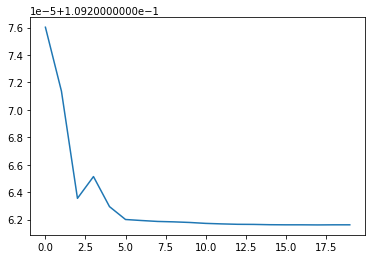

In [15]:
plt.plot(np.arange(epochs), diffs)

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


tensor([0.2066, 0.7537, 0.6701, 0.0000, 0.7911, 0.5914, 0.3177]) tensor(0.4758)


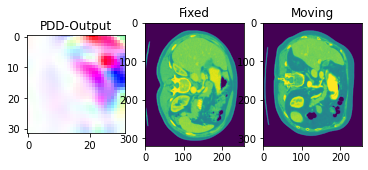

In [16]:
net.eval()
reg.eval()

feat00 = net(fixed.unsqueeze(0))
feat50 = net(moving.unsqueeze(0))

cost_soft, pred_xy = reg(feat00,feat50)
teacher_out = flow2(flow_in).cpu()
teacher_grid = F.grid_sample(teacher_out, grid_xy)

dense_flow_fit = F.interpolate(pred_xy.transpose(0,1).view(1,2,grid_size,grid_size),size=(h,w),mode='bicubic')
#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,h,w),align_corners=False)
warped_seg = F.grid_sample(moving_seg.float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False)
d1 = dice_coeff(fixed_seg,warped_seg.squeeze(),8)
print(d1,d1.mean())

plt.subplot(131)
plt.title("PDD-Output")
plt.imshow(showFlow(pred_xy.transpose(0,1).reshape(2,grid_size,grid_size).detach()))

plt.subplot(132)
plt.title('Fixed')
plt.imshow(fixed.detach().squeeze())

plt.subplot(133)
plt.title('Moving')
plt.imshow(moving.detach().squeeze())

## Let's get a small pdd_net to learn FlowNet2 warpings

trying to overfit on the wapred data of the flownet2.

In [17]:
net = OBELISK2d()
reg = deeds2d()
init_weights(net)
net.train()
reg.train()

# 20 epochs should be fine for overfitting
epochs = 30
optimizer = torch.optim.Adam(list(net.parameters())+list(reg.parameters()),lr=0.05)

disp_range = 0.25#0.25
displacement_width = 15#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2) 
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2)

# Testing with only one image to overfit on the flow and check if it works
# verfitting with upscale
diffs = []
for i in range(epochs):
    optimizer.zero_grad()
        
    # Genrate the flow we want to approximate
    teacher_flow = flow2(flow_in).cpu()
    warped_moving_teacher = warpImage(labelMatrixOneHot(moving_seg,9), teacher_flow)

    # Generate the pdd-output
    fixed.requires_grad = True
    moving.requires_grad=True
    
    feat00 = net(fixed.unsqueeze(0))
    feat50 = net(moving.unsqueeze(0))
    
    soft_cost, pred_xy = reg(feat00,feat50)
    pred_xy = pred_xy.view(1,grid_size,grid_size,2)
    
    diffloss = 1.5*((pred_xy[0,:,1:,:]-pred_xy[0,:,:-1,:])**2).mean()+\
            1.5*((pred_xy[0,1:,:,:]-pred_xy[0,:-1,:,:])**2).mean()+\
            1.5*((pred_xy[0,:,:,1:]-pred_xy[0,:,:,:-1])**2).mean()
    
    warped_seg = (F.grid_sample(labelMatrixOneHot(moving_seg,9).float(),grid_xy+shift_xy,padding_mode='border')\
                          *soft_cost.view(1,-1,grid_size**2,displacement_width**2)).sum(1,keepdim=True)
    warped_teacher = F.grid_sample(warped_moving_teacher, grid_xy)
    
    diff =(diffloss + (warped_teacher-warped_seg)).mean()
    diff.backward()
    diffs.append(diff.item())
    optimizer.step()

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


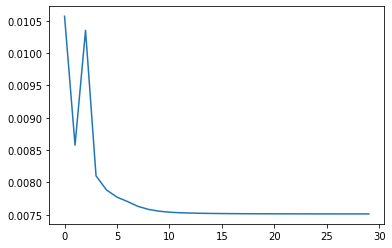

In [18]:
plt.plot(np.arange(epochs), diffs)

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


tensor([0.2066, 0.7537, 0.7047, 0.0000, 0.7932, 0.5252, 0.3034]) tensor(0.4695)


/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


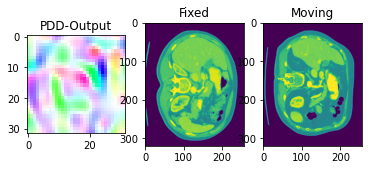

In [19]:
net.eval()
reg.eval()

feat00 = net(fixed.unsqueeze(0))
feat50 = net(moving.unsqueeze(0))

cost_soft, pred_xy = reg(feat00,feat50)
teacher_out = flow2(flow_in).cpu()
teacher_grid = F.grid_sample(teacher_out, grid_xy)
dense_flow_fit = F.interpolate(pred_xy.transpose(0,1).view(1,2,grid_size,grid_size),size=(h,w),mode='bicubic')
#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,h,w),align_corners=False)
warped_seg = F.grid_sample(moving_seg.float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False)
d1 = dice_coeff(fixed_seg,warped_seg.squeeze(),8)
print(d1,d1.mean())

plt.subplot(131)
plt.title("PDD-Output")
plt.imshow(showFlow(pred_xy.transpose(0,1).reshape(2,grid_size,grid_size).detach()))

plt.subplot(132)
plt.title('Fixed')
plt.imshow(fixed.detach().squeeze())

plt.subplot(133)
plt.title('Moving')
plt.imshow(moving.detach().squeeze())

## Train Pdd with Flow2 as teacher
Only try to learn the flow estimation from the flownet

This is to approximate the teacher and only the teacher output

In [20]:
class_weight = torch.sqrt(1.0/(torch.bincount(segs.view(-1)).float()))
class_weight = class_weight/class_weight.mean()
class_weight[0] = 0.15
class_weight = class_weight.cpu()

In [21]:
from torch.autograd import Variable
epochs = 1000
lr = 0.025
#delta = 0.8

net = OBELISK2d()
reg = deeds2d()
net.train()
reg.train()

init_weights(net)

optimizer = torch.optim.Adam(params=list(net.parameters()) + list(reg.parameters()), lr=lr)

torch.manual_seed(10)
# Now, we prepare our train & test dataset.
test_set = torch.LongTensor([35, 41, 0, 4, 39, 17])
train_set = torch.arange(43)
for idx in test_set:
    train_set = train_set[train_set != idx]

diffs=[]
for epoch in range(epochs):

    # get training examples
    rnd_train_idx = torch.randperm(train_set.size(0))
    p_fix = train_set[rnd_train_idx[0]]
    p_mov = train_set[rnd_train_idx[1]]

    fixed = imgs[p_fix:p_fix+1,:,:] / 255
    moving = imgs[p_mov:p_mov+1,:,:] / 255
    #Flow output from teacher1
    
    fixed_seg = segs[p_fix:p_fix+1,:,:]
    moving_seg = segs[p_mov:p_mov+1,:,:]
        
    flow_in = preprocessing_flownet(fixed.reshape(h,w,C),moving.reshape(h,w,C)).cuda()
    teacher_flow = flow2(flow_in).cpu()
    warped_moving_teacher = warpImage(labelMatrixOneHot(moving_seg,9), teacher_flow)

    
    optimizer.zero_grad()
    
    fixed = Variable(fixed, requires_grad=True)           #fixed
    moving = Variable(moving, requires_grad=True)         #moving
    
    feat00 = net(fixed.unsqueeze(0))
    feat50 = net(moving.unsqueeze(0))

    # Need some help here. I am not using the soft_cost at all. Not sure how tho
    soft_cost, pred_xy = reg(feat00,feat50)
    
    pred_xy = pred_xy.view(1,grid_size,grid_size,2)
    
    diffloss = 1.5*((pred_xy[0,:,1:,:]-pred_xy[0,:,:-1,:])**2).mean()+\
            1.5*((pred_xy[0,1:,:,:]-pred_xy[0,:-1,:,:])**2).mean()+\
            1.5*((pred_xy[0,:,:,1:]-pred_xy[0,:,:,:-1])**2).mean()
    
    warped_seg = (F.grid_sample(labelMatrixOneHot(moving_seg,9).float(),grid_xy+shift_xy,padding_mode='border')\
                          *soft_cost.view(1,-1,grid_size**2,displacement_width**2)).sum(1,keepdim=True)
    warped_teacher = F.grid_sample(warped_moving_teacher, grid_xy).detach()

    teacher_loss = torch.pow((warped_seg - warped_teacher),2)
    loss = (diffloss + teacher_loss).mean()
    #loss = (3/4 * orig_labelloss + (1/4 * teacher_loss)).mean()
    loss.backward()
    diffs.append(loss.item())
    
    #diff.backward()
    #diffs.append(diff.item())
    optimizer.step()

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


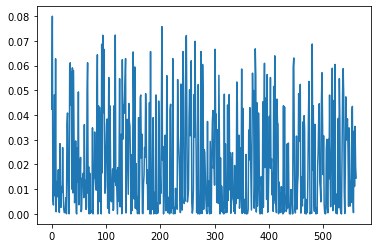

In [22]:
plt.plot(np.arange(epochs), diffs)

In [23]:
net.eval()
reg.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]
p_mov = test_set[rnd_test_idx[1]]

fixed = imgs[p_fix:p_fix+1,:,:] / 255
moving = imgs[p_mov:p_mov+1,:,:] / 255

fixed_seg = segs[p_fix:p_fix+1,:,:]
moving_seg = segs[p_mov:p_mov+1,:,:]

feat1 = net(fixed.unsqueeze(0))
feat2 = net(moving.unsqueeze(0))

soft_cost, pred_xy = reg(feat1,feat2)

dense_flow_fit = F.interpolate(pred_xy.transpose(0,1).view(1,2,grid_size,grid_size),size=(h,w),mode='bicubic')
#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,h,w),align_corners=False)
warped_seg = F.grid_sample(moving_seg.float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False)
d1 = dice_coeff(fixed_seg,warped_seg.squeeze(),8)
print(d1,d1.mean())

tensor([0., 0., 0., 0., 0., 0., 0.]) tensor(0.)


/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


 Somehow the flow alone is not enough.

## Using Flow2 as teacher and training on regular data
combining the teacher loss with the data loss

With a very high delta (not using the flownet it works...)

In [24]:
from torch.autograd import Variable
epochs = 1000
lr = 0.05
delta = 0.5

net = OBELISK2d()
reg = deeds2d()
net.train()
reg.train()

init_weights(net)

optimizer = torch.optim.Adam(params=list(net.parameters()) + list(reg.parameters()), lr=lr)

disp_range = 0.25#0.25
displacement_width = 15#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2) 
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2)

total_loss = []

kl_loss = torch.nn.KLDivLoss()

torch.manual_seed(10)

pat_indices = torch.cat((torch.arange(0, 17), torch.arange(18, 43)), 0)

rnd_perm_idc = torch.randperm(pat_indices.size(0))
pat_indices = pat_indices[rnd_perm_idc]

# Now, we prepare our train & test dataset.
test_set = torch.LongTensor([35, 41, 0, 4, 39, 17])
train_set = torch.arange(43)
for idx in test_set:
    train_set = train_set[train_set != idx]

diffs = []
for epoch in range(epochs):
     # get training examples
    rnd_train_idx = torch.randperm(train_set.size(0))
    p_fix = train_set[rnd_train_idx[0]]
    p_mov = train_set[rnd_train_idx[1]]

    fixed = imgs[p_fix:p_fix+1,:,:] / 255
    moving = imgs[p_mov:p_mov+1,:,:] / 255
    #Flow output from teacher1
    
    fixed_seg = segs[p_fix:p_fix+1,:,:]
    moving_seg = segs[p_mov:p_mov+1,:,:]
        
    flow_in = preprocessing_flownet(fixed.reshape(h,w,C),moving.reshape(h,w,C)).cuda()
    teacher_flow = flow2(flow_in).cpu()
    warped_moving_teacher = warpImage(labelMatrixOneHot(moving_seg,9), teacher_flow)

    
    optimizer.zero_grad()
    
    fixed = Variable(fixed, requires_grad=True)           #fixed
    moving = Variable(moving, requires_grad=True)         #moving
    
    feat00 = net(fixed.unsqueeze(0))
    feat50 = net(moving.unsqueeze(0))

    # Need some help here. I am not using the soft_cost at all. Not sure how tho
    soft_cost, pred_xy = reg(feat00,feat50)
    
    pred_xy = pred_xy.view(1,grid_size,grid_size,2)
    
    diffloss = 1.5*((pred_xy[0,:,1:,:]-pred_xy[0,:,:-1,:])**2).mean()+\
            1.5*((pred_xy[0,1:,:,:]-pred_xy[0,:-1,:,:])**2).mean()+\
            1.5*((pred_xy[0,:,:,1:]-pred_xy[0,:,:,:-1])**2).mean()
    
    warped_seg = (F.grid_sample(labelMatrixOneHot(moving_seg,9).float(),grid_xy+shift_xy,padding_mode='border')\
                          *soft_cost.view(1,-1,grid_size**2,displacement_width**2)).sum(1,keepdim=True)
    warped_teacher = F.grid_sample(warped_moving_teacher, grid_xy).detach()

    teacher_loss = torch.pow((warped_seg - warped_teacher),2).mean()
    
    nonlocal_label = (F.grid_sample(labelMatrixOneHot(moving_seg,9).float(),grid_xy+shift_xy,padding_mode='border')\
                          *soft_cost.view(1,-1,grid_size**2,displacement_width**2)).sum(1,keepdim=True)
    fixed_label = F.grid_sample(labelMatrixOneHot(fixed_seg,9).float(),grid_xy,padding_mode='border')#.long().squeeze(1)

    orig_labelloss = ((nonlocal_label-fixed_label)**2).mean()
    
    
    loss = (diffloss + (1-delta)*teacher_loss + delta*orig_labelloss)
    loss.backward()
    diffs.append(loss.item())
    
    #diff.backward()
    #diffs.append(diff.item())
    optimizer.step()

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


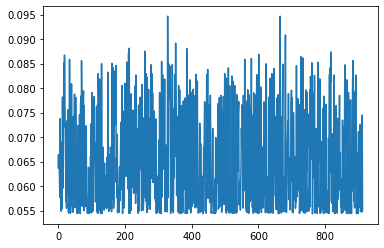

In [25]:
plt.plot(np.arange(epochs), diffs)

In [26]:
net.eval()
reg.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]
p_mov = test_set[rnd_test_idx[1]]

fixed = imgs[p_fix:p_fix+1,:,:] / 255
moving = imgs[p_mov:p_mov+1,:,:] / 255

fixed_seg = segs[p_fix:p_fix+1,:,:]
moving_seg = segs[p_mov:p_mov+1,:,:]

feat1 = net(fixed.unsqueeze(0))
feat2 = net(moving.unsqueeze(0))

soft_cost, pred_xy = reg(feat1,feat2)

dense_flow_fit = F.interpolate(pred_xy.transpose(0,1).view(1,2,grid_size,grid_size),size=(h,w),mode='bicubic')
#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,h,w),align_corners=False)
warped_seg = F.grid_sample(moving_seg.float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False)
d1 = dice_coeff(fixed_seg,warped_seg.squeeze(),8)
print(d1,d1.mean())

tensor([0., 0., 0., 0., 0., 0., 0.]) tensor(0.)


/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


## Playing with KLDiv
Using klDiv and the learning diff and loss.
Setting delta to different values, and check, which one learnes the best

In [27]:
from torch.autograd import Variable
epochs = 1000
lr = 0.05
delta = 0.5

net = OBELISK2d()
reg = deeds2d()
net.train()
reg.train()

init_weights(net)

optimizer = torch.optim.Adam(params=list(net.parameters()) + list(reg.parameters()), lr=lr)

disp_range = 0.25#0.25
displacement_width = 15#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2) 
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2)

total_loss = []

kl_loss = torch.nn.KLDivLoss()

torch.manual_seed(10)

pat_indices = torch.cat((torch.arange(0, 17), torch.arange(18, 43)), 0)

rnd_perm_idc = torch.randperm(pat_indices.size(0))
pat_indices = pat_indices[rnd_perm_idc]

# Now, we prepare our train & test dataset.
test_set = torch.LongTensor([35, 41, 0, 4, 39, 17])
train_set = torch.arange(43)
for idx in test_set:
    train_set = train_set[train_set != idx]

diffs = []
for epoch in range(epochs):
     # get training examples
    rnd_train_idx = torch.randperm(train_set.size(0))
    p_fix = train_set[rnd_train_idx[0]]
    p_mov = train_set[rnd_train_idx[1]]

    fixed = imgs[p_fix:p_fix+1,:,:] / 255
    moving = imgs[p_mov:p_mov+1,:,:] / 255
    #Flow output from teacher1
    
    fixed_seg = segs[p_fix:p_fix+1,:,:]
    moving_seg = segs[p_mov:p_mov+1,:,:]
        
    flow_in = preprocessing_flownet(fixed.reshape(h,w,C),moving.reshape(h,w,C)).cuda()
    teacher_flow = flow2(flow_in).cpu()
    warped_moving_teacher = warpImage(labelMatrixOneHot(moving_seg,9), teacher_flow)

    
    optimizer.zero_grad()
    
    fixed = Variable(fixed, requires_grad=True)           #fixed
    moving = Variable(moving, requires_grad=True)         #moving
    
    feat00 = net(fixed.unsqueeze(0))
    feat50 = net(moving.unsqueeze(0))

    # Need some help here. I am not using the soft_cost at all. Not sure how tho
    soft_cost, pred_xy = reg(feat00,feat50)
    
    pred_xy = pred_xy.view(1,grid_size,grid_size,2)
    
    diffloss = 1.5*((pred_xy[0,:,1:,:]-pred_xy[0,:,:-1,:])**2).mean()+\
            1.5*((pred_xy[0,1:,:,:]-pred_xy[0,:-1,:,:])**2).mean()+\
            1.5*((pred_xy[0,:,:,1:]-pred_xy[0,:,:,:-1])**2).mean()
    
    warped_seg = (F.grid_sample(labelMatrixOneHot(moving_seg,9).float(),grid_xy+shift_xy,padding_mode='border')\
                          *soft_cost.view(1,-1,grid_size**2,displacement_width**2)).sum(1,keepdim=True)
    warped_teacher = F.grid_sample(warped_moving_teacher, grid_xy).detach()

    teacher_loss = - kl_loss(warped_seg,warped_teacher)
    
    
    nonlocal_label = (F.grid_sample(labelMatrixOneHot(moving_seg,9).float(),grid_xy+shift_xy,padding_mode='border')\
                          *soft_cost.view(1,-1,grid_size**2,displacement_width**2)).sum(1,keepdim=True)
    fixed_label = F.grid_sample(labelMatrixOneHot(fixed_seg,9).float(),grid_xy,padding_mode='border')#.long().squeeze(1)

    orig_labelloss = ((nonlocal_label-fixed_label)**2).mean()

    loss = diffloss + (1-delta)*teacher_loss + delta*orig_labelloss
    loss.backward()
    diffs.append(loss.item())
    
    #diff.backward()
    #diffs.append(diff.item())
    optimizer.step()

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in 

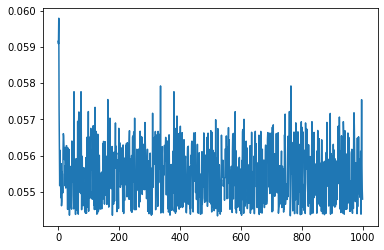

In [28]:
plt.plot(np.arange(epochs), diffs)

In [29]:
net.eval()
reg.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]
p_mov = test_set[rnd_test_idx[1]]

fixed = imgs[p_fix:p_fix+1,:,:] / 255
moving = imgs[p_mov:p_mov+1,:,:] / 255

fixed_seg = segs[p_fix:p_fix+1,:,:]
moving_seg = segs[p_mov:p_mov+1,:,:]

feat1 = net(fixed.unsqueeze(0))
feat2 = net(moving.unsqueeze(0))

soft_cost, pred_xy = reg(feat1,feat2)

dense_flow_fit = F.interpolate(pred_xy.transpose(0,1).view(1,2,grid_size,grid_size),size=(h,w),mode='bicubic')
#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,h,w),align_corners=False)
warped_seg = F.grid_sample(moving_seg.float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False)
d1 = dice_coeff(fixed_seg,warped_seg.squeeze(),8)
print(d1,d1.mean())

tensor([0.5856, 0.8351, 0.0000, 0.0000, 0.6483, 0.6209, 0.4499]) tensor(0.4485)


/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


# Verdict
Something worked. Not sure what. I will do some investigation and then can present the results as prestudy. 
The idea: Use different losses to train a network.
